# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
!pip install detoxify
from detoxify import Detoxify
from nltk.tokenize import TweetTokenizer
from ast import literal_eval
import string
import numpy as np

Mounted at /content/gdrive
     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.3 MB/s 
     |████████████████████████████████| 6.5 MB 36.7 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 
     |████████████████████████████████| 895 kB 47.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Import data and data preprocessing

In [2]:
tsd_test = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_test.csv')
tsd_test['spans'] = tsd_test['spans'].apply(literal_eval)
tsd_test.head(10)

,spans,text
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",That's right. They are not normal. And I am st...
1,"[81, 82, 83, 84, 85, 86]","""Watch people die from taking away their healt..."
2,[],tens years ago i contacted the PDR and suggest...
3,[],The parallels between the ANC and the Sicilian...
4,[],Intel Community: ‘How can we work for a Presid...
5,"[129, 130, 131, 132, 133, 134]",I live in an area that saw major flood damage ...
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",Elaine Marie Jeffers sounds like a sociopath 😕.
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",A rock has more mental horsepower than the ind...
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...","Ha ha, HILLARY LOST. All you hillary fools nee..."
9,"[94, 95, 96, 97]",Yes....it is to be expected....oddly enough it...


In [3]:
# Lowercase all characters
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.lower())

# Replace \n by space, so the index won't be effected
# Replace emojis by ?
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.replace('\n', ' '))
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

# Remove punctuations
def remove_punctuation(text):
    punctuationfree = []
    for i in text:
        if i not in string.punctuation:
            punctuationfree.append(i)
        else:
            punctuationfree.append(' '*len(i))
    if punctuationfree[-1] == ' ':
        punctuationfree = punctuationfree[:-1]
    punctuationfree = ''.join(punctuationfree)
    return punctuationfree

tsd_test['text'] = tsd_test['text'].apply(lambda x: remove_punctuation(x))

tsd_test.head(10)

,spans,text
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that s right they are not normal and i am st...
1,"[81, 82, 83, 84, 85, 86]",watch people die from taking away their healt...
2,[],tens years ago i contacted the pdr and suggest...
3,[],the parallels between the anc and the sicilian...
4,[],intel community how can we work for a presid...
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...",ha ha hillary lost all you hillary fools nee...
9,"[94, 95, 96, 97]",yes it is to be expected oddly enough it...


In [4]:
def build_sequence(text):
    tknzr2 = TweetTokenizer()
    tmp = tknzr2.tokenize(text)

    tokens = []
    token_span = []
    for each_token in tmp:
        if each_token not in string.punctuation:
            tokens.append(each_token)
            if len(token_span) != 0:
                tmp = text[token_span[len(token_span)-1][-1]+1:]
                start = tmp.find(each_token) + token_span[len(token_span)-1][-1]+1
                token_span.append(list(range(start, start + len(each_token))))
            else:
                token_span.append(list(range(0, len(each_token))))

    return tokens, token_span

tokens = []
token_spans = []

for index, row in tsd_test.iterrows():
    token, token_span = build_sequence(row['text'])
    tokens.append(token)
    token_spans.append(token_span)

tsd_test['token'] = tokens
tsd_test['token_span'] = token_spans

tsd_test.head(10)

,spans,text,token,token_span
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that s right they are not normal and i am st...,"[that, s, right, they, are, not, normal, and, ...","[[0, 1, 2, 3], [5], [7, 8, 9, 10, 11], [14, 15..."
1,"[81, 82, 83, 84, 85, 86]",watch people die from taking away their healt...,"[watch, people, die, from, taking, away, their...","[[0, 1, 2, 3, 4], [7, 8, 9, 10, 11, 12], [14, ..."
2,[],tens years ago i contacted the pdr and suggest...,"[tens, years, ago, i, contacted, the, pdr, and...","[[0, 1, 2, 3], [5, 6, 7, 8, 9], [11, 12, 13], ..."
3,[],the parallels between the anc and the sicilian...,"[the, parallels, between, the, anc, and, the, ...","[[0, 1, 2], [4, 5, 6, 7, 8, 9, 10, 11, 12], [1..."
4,[],intel community how can we work for a presid...,"[intel, community, how, can, we, work, for, a,...","[[0, 1, 2, 3, 4], [6, 7, 8, 9, 10, 11, 12, 13,..."
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[i, live, in, an, area, that, saw, major, floo...","[[0], [2, 3, 4, 5], [7, 8], [10, 11], [13, 14,..."
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath,"[elaine, marie, jeffers, sounds, like, a, soci...","[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [13, 1..."
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[a, rock, has, more, mental, horsepower, than,...","[[0], [2, 3, 4, 5], [7, 8, 9], [11, 12, 13, 14..."
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...",ha ha hillary lost all you hillary fools nee...,"[ha, ha, hillary, lost, all, you, hillary, foo...","[[0, 1], [3, 4], [7, 8, 9, 10, 11, 12, 13], [1..."
9,"[94, 95, 96, 97]",yes it is to be expected oddly enough it...,"[yes, it, is, to, be, expected, oddly, enough,...","[[0, 1, 2], [7, 8], [10, 11], [13, 14], [16, 1..."


# Predict

In [5]:
# Import pre-trained toxicBERT model from Huggingface
unbiased_model = Detoxify('unbiased', device='cuda')

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.3-alpha/toxic_debiased-c7548aa0.ckpt" to /root/.cache/torch/hub/checkpoints/toxic_debiased-c7548aa0.ckpt


  0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [6]:
spans_predicted = []
for index, row in tsd_test.iterrows():
    tmp = []
    toxic_prediction = unbiased_model.predict(row['token'])
    for i in range(0, len(toxic_prediction['toxicity'])):
        if toxic_prediction['toxicity'][i] > 0.9:
            tmp += row['token_span'][i]
    spans_predicted.append(tmp)

tsd_test['spans_predicted'] = spans_predicted

tsd_test.head(10)

,spans,text,token,token_span,spans_predicted
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that s right they are not normal and i am st...,"[that, s, right, they, are, not, normal, and, ...","[[0, 1, 2, 3], [5], [7, 8, 9, 10, 11], [14, 15...","[140, 141, 142, 143, 144, 145, 146]"
1,"[81, 82, 83, 84, 85, 86]",watch people die from taking away their healt...,"[watch, people, die, from, taking, away, their...","[[0, 1, 2, 3, 4], [7, 8, 9, 10, 11, 12], [14, ...","[81, 82, 83, 84, 85, 86]"
2,[],tens years ago i contacted the pdr and suggest...,"[tens, years, ago, i, contacted, the, pdr, and...","[[0, 1, 2, 3], [5, 6, 7, 8, 9], [11, 12, 13], ...","[483, 484, 485, 486, 487, 488, 489, 490]"
3,[],the parallels between the anc and the sicilian...,"[the, parallels, between, the, anc, and, the, ...","[[0, 1, 2], [4, 5, 6, 7, 8, 9, 10, 11, 12], [1...","[162, 163, 164, 165, 166, 413, 414, 415, 416, ..."
4,[],intel community how can we work for a presid...,"[intel, community, how, can, we, work, for, a,...","[[0, 1, 2, 3, 4], [6, 7, 8, 9, 10, 11, 12, 13,...","[663, 664, 665, 666, 667, 668, 669]"
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[i, live, in, an, area, that, saw, major, floo...","[[0], [2, 3, 4, 5], [7, 8], [10, 11], [13, 14,...","[129, 130, 131, 132, 133, 134]"
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath,"[elaine, marie, jeffers, sounds, like, a, soci...","[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [13, 1...",[]
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[a, rock, has, more, mental, horsepower, than,...","[[0], [2, 3, 4, 5], [7, 8, 9], [11, 12, 13, 14...","[55, 56, 57, 58, 59, 60, 61, 62]"
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...",ha ha hillary lost all you hillary fools nee...,"[ha, ha, hillary, lost, all, you, hillary, foo...","[[0, 1], [3, 4], [7, 8, 9, 10, 11, 12, 13], [1...","[37, 38, 39, 40, 41, 134, 135, 136, 137, 204, ..."
9,"[94, 95, 96, 97]",yes it is to be expected oddly enough it...,"[yes, it, is, to, be, expected, oddly, enough,...","[[0, 1, 2], [7, 8], [10, 11], [13, 14], [16, 1...","[94, 95, 96, 97]"


In [7]:
#print(tsd_test['text'][2])

token = tsd_test['token'][2]

gg = unbiased_model.predict(['example',  'text'])

for i in range(0, len(gg['toxicity'])):
    if gg['toxicity'][i] > 0.8:
        print(token[i])

In [8]:
unbiased_model.predict(['ignorant'])

{'identity_attack': [0.0012933870311826468],
 'insult': [0.9845983982086182],
 'obscene': [0.0009734737686812878],
 'severe_toxicity': [7.48553648008965e-05],
 'sexual_explicit': [0.00024171420955099165],
 'threat': [0.00017945455329027027],
 'toxicity': [0.9887285232543945]}

In [9]:
print(tsd_test['text'][2][480:493])

ut ignorant p


# Evaluation

In [10]:
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # read the predictions
    pred_lines = pred.readlines()
    # read the ground truth
    gold_lines = gold.readlines()

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

    else:
        sys.exit('Predictions and gold data have different number of lines.')

In [11]:
tsd_test["f1_scores"] = tsd_test.apply(lambda row: f1(row.spans_predicted, row.spans), axis=1)
tsd_test.head(10)

,spans,text,token,token_span,spans_predicted,f1_scores
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that s right they are not normal and i am st...,"[that, s, right, they, are, not, normal, and, ...","[[0, 1, 2, 3], [5], [7, 8, 9, 10, 11], [14, 15...","[140, 141, 142, 143, 144, 145, 146]",0.482759
1,"[81, 82, 83, 84, 85, 86]",watch people die from taking away their healt...,"[watch, people, die, from, taking, away, their...","[[0, 1, 2, 3, 4], [7, 8, 9, 10, 11, 12], [14, ...","[81, 82, 83, 84, 85, 86]",1.000000
2,[],tens years ago i contacted the pdr and suggest...,"[tens, years, ago, i, contacted, the, pdr, and...","[[0, 1, 2, 3], [5, 6, 7, 8, 9], [11, 12, 13], ...","[483, 484, 485, 486, 487, 488, 489, 490]",0.000000
3,[],the parallels between the anc and the sicilian...,"[the, parallels, between, the, anc, and, the, ...","[[0, 1, 2], [4, 5, 6, 7, 8, 9, 10, 11, 12], [1...","[162, 163, 164, 165, 166, 413, 414, 415, 416, ...",0.000000
4,[],intel community how can we work for a presid...,"[intel, community, how, can, we, work, for, a,...","[[0, 1, 2, 3, 4], [6, 7, 8, 9, 10, 11, 12, 13,...","[663, 664, 665, 666, 667, 668, 669]",0.000000
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[i, live, in, an, area, that, saw, major, floo...","[[0], [2, 3, 4, 5], [7, 8], [10, 11], [13, 14,...","[129, 130, 131, 132, 133, 134]",1.000000
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath,"[elaine, marie, jeffers, sounds, like, a, soci...","[[0, 1, 2, 3, 4, 5], [7, 8, 9, 10, 11], [13, 1...",[],0.000000
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[a, rock, has, more, mental, horsepower, than,...","[[0], [2, 3, 4, 5], [7, 8, 9], [11, 12, 13, 14...","[55, 56, 57, 58, 59, 60, 61, 62]",0.500000
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...",ha ha hillary lost all you hillary fools nee...,"[ha, ha, hillary, lost, all, you, hillary, foo...","[[0, 1], [3, 4], [7, 8, 9, 10, 11, 12, 13], [1...","[37, 38, 39, 40, 41, 134, 135, 136, 137, 204, ...",0.588235
9,"[94, 95, 96, 97]",yes it is to be expected oddly enough it...,"[yes, it, is, to, be, expected, oddly, enough,...","[[0, 1, 2], [7, 8], [10, 11], [13, 14], [16, 1...","[94, 95, 96, 97]",1.000000


F1 = 0.64 ± 0.01


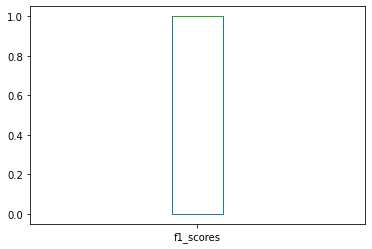

In [12]:
from scipy.stats import sem
_ = tsd_test.f1_scores.plot(kind="box")
print (f"F1 = {tsd_test.f1_scores.mean():.2f} ± {sem(tsd_test.f1_scores):.2f}")

In [13]:
# make sure that the ids match the ones of the scores
predictions = tsd_test.spans_predicted.to_list()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head spans-pred.txt

0	[140, 141, 142, 143, 144, 145, 146]
1	[81, 82, 83, 84, 85, 86]
2	[483, 484, 485, 486, 487, 488, 489, 490]
3	[162, 163, 164, 165, 166, 413, 414, 415, 416, 417, 418, 419, 420]
4	[663, 664, 665, 666, 667, 668, 669]
5	[129, 130, 131, 132, 133, 134]
6	[]
7	[55, 56, 57, 58, 59, 60, 61, 62]
8	[37, 38, 39, 40, 41, 134, 135, 136, 137, 204, 205, 206, 207, 208, 321, 322, 323, 324, 325, 326]
9	[94, 95, 96, 97]


In [14]:
gold = tsd_test.spans.to_list()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-gold.txt", "w") as out:
  for uid, text_scores in zip(ids, gold):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head spans-gold.txt


0	[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
1	[81, 82, 83, 84, 85, 86]
2	[]
3	[]
4	[]
5	[129, 130, 131, 132, 133, 134]
6	[35, 36, 37, 38, 39, 40, 41, 42, 43]
7	[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
8	[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, 205, 206, 207, 208]
9	[94, 95, 96, 97]


In [15]:
predictions = open("spans-pred.txt", "r")
gold = open("spans-gold.txt", "r")

score = evaluate(predictions, gold)
print(score)

(0.6389699750148436, 0.009770456859103476)
